<a href="https://colab.research.google.com/github/Samarth-991/Medical-Data-Handling/blob/main/MusicSound_DataAnalyis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Audio Classification using DeepLearning for Image Classification
We will be using Freesound General-Purpose Audio Tagging dataset which can be grapped from Kaggle - link.

In this dataset, there is a set of 9473 wav files for training in the audio_train folder and a set of 9400 wav files that constitues the test set.

Sounds in this dataset are unequally distributed in the following 41 categories of the Google’s AudioSet Ontology:

In [1]:
import numpy as np
import csv
import pandas as pd
import time
import cv2
import os
import glob
import random
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow.keras import Model
from  tensorflow.keras.preprocessing import image

from IPython.display import Audio
from scipy.io import wavfile
from scipy.signal import resample

import gc 
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)
print(cv2.__version__)
rand = np.random.seed(46)

2.4.0
4.1.2


In [2]:
import librosa 
import librosa.display
import IPython
import IPython.display as ipd
from scipy.io import wavfile

images = '/content/Data/images_original'
genres = '/content/Data/genres_original'

In [3]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ## data 
# !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
# ! unzip /content/gtzan-dataset-music-genre-classification.zip
# ! rm -rf /content/gtzan-dataset-music-genre-classification.zip

In [4]:
def plot_spectrogram(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    
    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')
    # draw a color bar
    plt.colorbar(format='%+02.0f dB')
    # Make the figure layout compact
    plt.tight_layout()

In [5]:
sound_data = pd.read_csv('/content/Data/features_30_sec.csv')
sound_data

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

metal        100
hiphop       100
reggae       100
jazz         100
disco        100
country      100
classical    100
blues        100
pop          100
rock         100
Name: label, dtype: int64


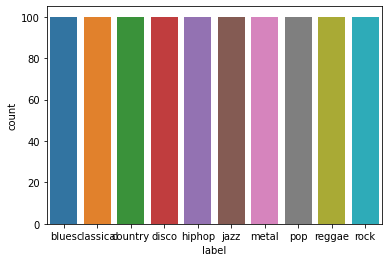

In [6]:
# check data balanced or not 
sns.countplot(sound_data['label'])
print(sound_data['label'].value_counts())

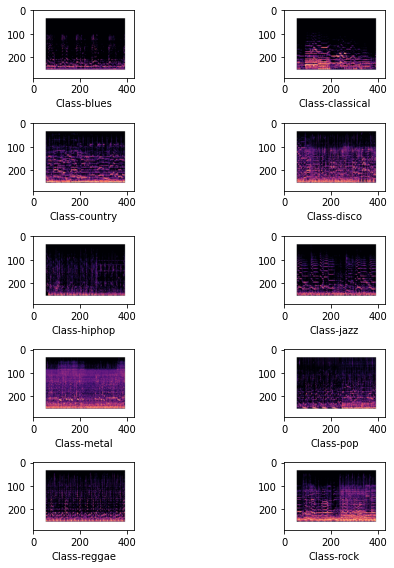

In [7]:
df = sound_data.groupby(['label'])['filename']
imgs_perId = []
for id , name in df:
    img_path = os.path.join(str(id),name[random.choice(name.index)])
    imgs_perId.append(img_path)
# print(imgs_perId)

# Display Multiple images in a matix 
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 5

for i in range(1, columns*rows +1):
    img_path = imgs_perId[i-1]
    label_folder = img_path.split('.')[0]
    img_path = os.path.join(images,label_folder+img_path.split('.')[1]+'.png')
    img = plt.imread(img_path)
    fig.add_subplot(rows, columns, i,xlabel="Class-"+label_folder.split('/')[0])
    plt.imshow(img)
fig.tight_layout()


In [8]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = resample(waveform, desired_length)
  return desired_sample_rate, waveform

# wav_file_name = 'speech_whistling2.wav'
wav_file_name = '/content/Data/genres_original/blues/blues.00000.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 30.01s
Size of the input: 480213


In [9]:
# !pip install tpot
#from tpot import TPOTClassifier
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [10]:
# shuffle the DataFrame rows 
sound_data = sound_data.sample(frac = 1) 
sound_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
576,jazz.00076.wav,661794,0.303204,0.087000,0.119156,0.003013,1733.471676,147305.969515,2067.771440,174358.504430,3379.588767,1.247290e+06,0.068700,0.000767,-3.616244e-06,0.015180,-0.000046,0.000526,117.453835,-154.323517,3352.635254,110.695793,510.107300,-22.306967,748.752869,21.169392,175.022217,4.263515,110.151535,4.752450,83.927879,-4.099986,72.681229,-1.006059,51.672100,-6.405927,89.839233,-9.242157,45.147503,-3.631923,35.907864,-5.505253,34.334999,0.547401,42.459400,-0.500197,36.483524,-4.802399,29.643356,-11.205058,42.574501,-3.927142,30.083775,-1.457928,47.042614,-4.403174,44.479271,-10.596965,46.879120,jazz
629,metal.00029.wav,661504,0.440967,0.079543,0.089029,0.000429,2954.984809,257121.128595,2478.290264,30442.108953,5928.167427,4.462161e+05,0.163280,0.003348,-8.189047e-07,0.003587,-0.000028,0.002051,123.046875,-103.599892,1348.563599,73.845474,310.793274,-16.142157,187.317139,53.168262,161.695663,-25.080454,166.775909,33.997044,144.662323,-13.657199,101.959213,25.985947,90.961594,-18.905123,64.133583,18.667660,54.352089,-12.786475,47.448242,9.547082,31.958582,-16.154066,47.214394,8.774175,42.393929,-12.540708,34.083359,5.372025,37.844090,-8.105035,33.586605,6.670192,38.268536,-4.500066,40.489925,2.925767,36.995564,metal
557,jazz.00057.wav,661794,0.234168,0.092644,0.078136,0.002283,1378.524274,168329.629531,1773.676404,86900.504631,2584.908654,8.896191e+05,0.061859,0.001325,-4.338201e-03,0.007560,-0.000599,0.000214,95.703125,-248.030884,3241.810791,125.956253,401.456726,-12.608919,496.919769,30.273462,142.075806,-1.075209,102.893852,-2.226388,80.347870,1.928532,54.170994,0.229403,52.057205,2.700755,74.953621,-4.399659,57.814011,-6.444574,95.746140,-6.496408,53.562397,-3.991488,70.001930,2.322678,57.442112,0.349836,60.768044,-4.048587,49.173058,-1.498452,73.097794,-3.520071,94.470222,-6.187496,113.834229,-7.340963,90.994820,jazz
641,metal.00041.wav,661794,0.456134,0.075901,0.097609,0.000364,2269.128009,135794.165072,1928.953538,88450.196573,4186.459372,7.265238e+05,0.137348,0.001084,-1.571659e-03,0.004224,-0.002190,0.002530,117.453835,-100.384117,1325.951050,104.688103,394.065491,-57.247860,329.421875,56.568501,113.169205,-5.551697,93.510063,22.824835,101.307076,-6.165266,110.296234,23.091785,78.821548,-19.065331,50.222286,17.791447,52.025703,-13.772540,48.232338,9.958724,50.013187,-14.852403,48.860428,0.340110,71.158882,-7.333623,52.941803,6.971109,40.836742,-12.668804,40.830875,-0.556885,31.079792,-11.754225,37.405830,-1.540814,30.325340,metal
677,metal.00077.wav,661504,0.440846,0.078121,0.149150,0.000625,2740.920991,123106.217796,2301.912449,42740.769487,5408.656003,4.087410e+05,0.159919,0.001211,-9.084298e-06,0.010490,-0.000114,0.004293,151.999081,-42.010681,528.534607,86.989815,198.678177,-27.530127,232.540512,62.618126,142.081604,-27.000978,109.679787,32.335598,72.726288,-18.953333,82.701309,22.130354,32.238678,-14.319275,49.713634,19.503925,48.850876,-10.961795,45.174103,16.759821,57.777451,-12.376792,60.592205,10.512994,52.305267,-6.710442,56.975094,6.510389,42.208214,-9.198161,42.640999,6.566628,44.020481,-5.779749,32.889381,1.333079,39.510651,metal


In [11]:
labels = np.asarray(sound_data.label)
X = sound_data.drop(['filename','length','label'],axis=1)
print(X.shape)
print(labels.shape)

(1000, 57)
(1000,)


In [12]:
encoder = LabelEncoder()
Y = encoder.fit_transform(labels)
classes = (encoder.classes_)

In [13]:
# Since we already ran the classifier we will skip this part 
# tpot = TPOTClassifier(generations=3,verbosity=2,cv=3,random_state=42)
# tpot.fit(X_train,y_train)
# print(tpot.score(X_test, y_test))
# tpot.export('tpot_exported_pipeline_sounddataset.py')
from sklearn.ensemble import GradientBoostingClassifier
training_features, testing_features, training_target, testing_target = train_test_split(X, Y, random_state=42)
exported_pipeline = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_features=0.25, min_samples_leaf=14, min_samples_split=14, n_estimators=100, subsample=0.9000000000000001)
exported_pipeline.fit(training_features, training_target)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=0.25, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=14, min_samples_split=14,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.9000000000000001,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [14]:
results = exported_pipeline.predict(testing_features)

In [15]:
inference = pd.DataFrame({'Test_data':encoder.inverse_transform(testing_target),'Predicted':encoder.inverse_transform(results)})
inference.head()

,Test_data,Predicted
0,blues,blues
1,hiphop,disco
2,classical,classical
3,jazz,jazz
4,country,country


In [16]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print("[INFO] evaluating network...")
print("Accuracy : ",accuracy_score(testing_target,results))

[INFO] evaluating network...
Accuracy :  0.764


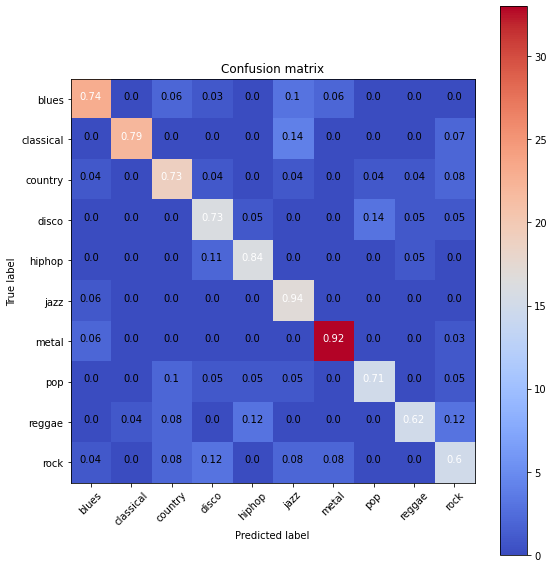

In [17]:
# compute confusion matrix
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.coolwarm)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

cnf_matrix = confusion_matrix(testing_target,results)
fig = plot_confusion_matrix(cnf_matrix,classes)

## Neural Networks


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)
print ("Trainnig data",x_train.shape)
print ("Train label",y_train.shape)
print ("Test data",x_test.shape)
print ("Test Label",y_test.shape)

Trainnig data (900, 57)
Train label (900,)
Test data (100, 57)
Test Label (100,)


In [19]:
m = tf.keras.models.Sequential()
m.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
m.add(tf.keras.layers.Dense(128, activation='relu'))
m.add(tf.keras.layers.Dense(64, activation='relu'))
m.add(tf.keras.layers.Dense(32, activation='relu'))
m.add(tf.keras.layers.Dense(len(classes), activation='softmax'))
m.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14848     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 58,410
Trainable params: 58,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = m.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_test,y_test))

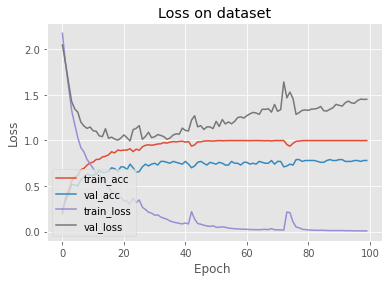

In [21]:
# plot the training loss and accuracy
N = len(history.history["accuracy"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Loss on dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [22]:
loss, acc  = m.evaluate(x_test, y_test, batch_size=128)
print('Loss = ',loss,'Accuracy = ',acc)

1/1 [==============================] - 0s 14ms/step - loss: 1.4515 - accuracy: 0.7800
Loss =  1.4515353441238403 Accuracy =  0.7799999713897705
